In [8]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

class StopExecution(Exception):
    def _render_traceback_(self):
        return []



In [9]:
import sys
sys.path.append("..")
import pickle as pkl
import hist
from analyzer.datasets import SampleManager
from analyzer.core import AnalysisResult
import math
import torch
import gpytorch
from torch.masked import masked_tensor, as_masked_tensor
import numpy as np

In [10]:
import matplotlib.pyplot as plt
from analyzer.plotting.plots_1d import drawAs1DHist
from analyzer.plotting.plots_2d import drawAs2DHist, addTitles2D
from analyzer.plotting.plottables import PlotObject
from analyzer.plotting.mplstyles import loadStyles
import analyzer.plotting as plot
loadStyles()

In [11]:
from fitting import regression



In [12]:
res = AnalysisResult.fromFile("../results/data_control.pkl")

In [13]:
sample_manager = SampleManager()
sample_manager.loadSamplesFromDirectory("../datasets")

In [14]:
res.results["CR0b_Data2018"].histograms["h_njet"] 

Hist(
  StrCategory(['CR0b_Data2018'], growth=True, name='dataset', label='Primary dataset'),
  Regular(10, 0, 10, name='nj', label='$n_{j}$'),
  storage=Weight()) # Sum: WeightedSum(value=1.40454e+07, variance=1.40454e+07)

In [15]:
hists = res.getMergedHistograms(sample_manager)

In [16]:
bkg_name="CR0b_Data2018"
complete_hist = hists["m14_vs_m24"]
narrowed = complete_hist
#orig =  complete_hist[...,hist.loc(1100):hist.loc(2500),hist.loc(400):hist.loc(2000)]
#narrowed =  complete_hist[...,hist.loc(0):hist.loc(3000),hist.loc(0):hist.loc(1)]
#orig =  complete_hist[...,hist.loc(1150):hist.loc(3000),hist.loc(0.4):hist.loc(1)]
#orig = orig / orig.values().max()
#orig =  complete_hist[...,hist.loc(1150):hist.loc(3000),hist.loc(400):hist.loc(3000)]#orig =  complete_hist[...,hist.loc(0):hist.loc(3000),hist.loc(0):hist.loc(3000)]
#narrowed = orig
#narrowed = orig[...,::hist.rebin(15),::hist.rebin(12)]
narrowed = narrowed[...,::hist.rebin(1),::hist.rebin(1)]

qcd_hist = narrowed[bkg_name,...]
#orig_qcd_hist = orig[bkg_name,...]

#sig_hist = narrowed["signal_312_1500_900",...]

qcd_hist = narrowed[bkg_name,...] 


In [17]:
torch.set_default_dtype(torch.float64)

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def addColorbar(ax, vals):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(vals, cax=cax)
    cax.get_yaxis().set_offset_position("left")
    ax.cax = cax

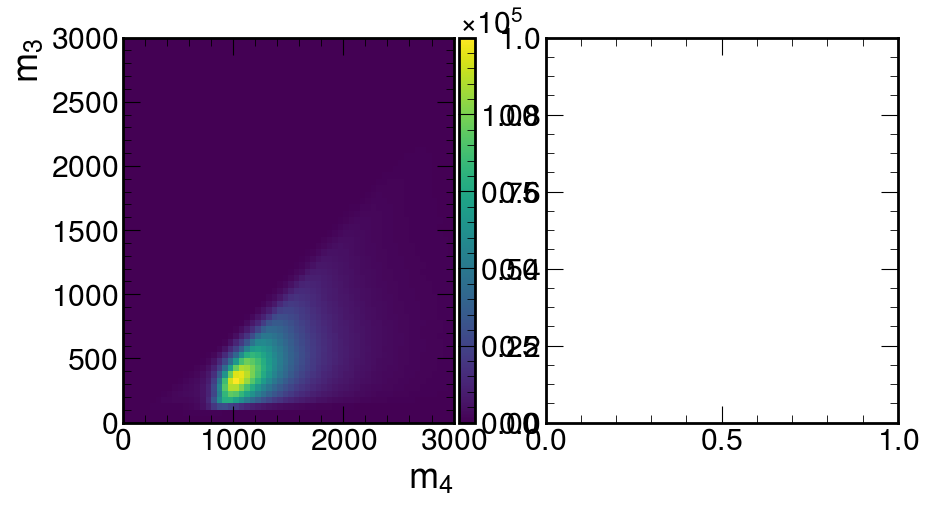

In [19]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
_ = drawAs2DHist(ax[0], PlotObject.fromHist(qcd_hist))
#_ = drawAs2DHist(ax[1], PlotObject.fromHist(sig_hist))

In [20]:
#sig_values = torch.from_numpy(sig_hist.values()).T
#(train, test), centers_mask = regression.preprocessHistograms(qcd_hist, [(0,0),(0.0,0.0)])
window = [(1350,1550),(420,580)]
#window=None
(raw_train, raw_test), (train, test),  value_scale = regression.preprocessHistograms(qcd_hist, window, exclude_less=0.0001)


In [21]:
class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self, odim=2):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(2, 1000))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(1000, 500))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(500, 50))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(50, odim))



In [22]:
class NNModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood,kernel=None,odim=2):
            super().__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            
            self.covar_module = kernel or gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2))
            feature_extractor = LargeFeatureExtractor(odim=odim)
            self.feature_extractor = feature_extractor

            # This module will scale the NN features so that they're nice values
            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            projected_x = self.feature_extractor(x)
            projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [23]:
i = train.inputs.cuda()

In [27]:
from fitting import regression
from gpytorch.kernels import ScaleKernel as SK
from gpytorch.kernels import RBFKernel as RBF

import fitting.models as models
#importlib.reload(models)
#importlib.reload(regression)


if torch.cuda.is_available():   
    print("Loading train to gpu")
    train_data = regression.DataValues(train.inputs.cuda(), train.outputs.cuda(), train.variances.cuda(), None)
    print("Loaded train to gpu")


grid_size = gpytorch.utils.grid.choose_grid_size(train.inputs,1.0)

# model,likelihood = regression.createModel(
#     train_data, 
#     kernel=SK(
#         gpytorch.kernels.GridInterpolationKernel(
#             gpytorch.kernels.RBFKernel(ard_num_dims=2), grid_size=grid_size, num_dims=2)
#     ))
#model,likelihood = regression.createModel(train_data, 
#kernel=SK(
#                                              gpytorch.kernels.RBFKernel(ard_num_dims=2) + 
#                                              gpytorch.kernels.LinearKernel(ard_num_dims=2,num_dimensions=2)
#                                          ))
#model,likelihood = regression.createModel(train_data, kernel=SK(gpytorch.kernels.MaternKernel(ard_num_dims=2)))
#model,likelihood = regression.createModel(train_data, kernel=SK(gpytorch.kernels.PiecewisePolynomialKernel(ard_num_dims=2)))
#model,likelihood = regression.createModel(train_data, model_maker= ExactProjGPModel )#model,likelihood = regression.createModel(train, kernel=SK(models.MatrixRBF()))
#model,likelihood = regression.createModel(train_data, kernel=SK(models.PeakedRBF(ard_num_dims=2)))

smk = gpytorch.kernels.SpectralMixtureKernel(ard_num_dims=2, num_mixtures=4)
gsmk=models.GeneralSpectralMixture(num_mixtures=1, ard_num_dims=2)
smk.initialize_from_data(train.inputs, train.outputs)
#gsmk.initialize_from_data(train.inputs, train.outputs)

grbf = models.GeneralRBF(ard_num_dims=2)
lk = gpytorch.kernels.LinearKernel(ard_num_dims=2,num_dimensions=2)

#model,likelihood = regression.createModel(train, kernel=gpytorch.kernels.SpectralMixtureKernel(ard_num_dims=2, num_mixtures=2))
#model,likelihood = regression.createModel(train, kernel=smk)
#model,likelihood = regression.createModel(train, model_maker=NNModel, kernel=gpytorch.kernels.RQKernel(ard_num_dims=2), odim=2)
model,likelihood = regression.createModel(train_data, kernel=grbf)




#model,likelihood = regression.createModel(train, kernel=gpytorch.kernels.SpectralDeltaKernel(num_dims=2, ard_num_dims=2))#model,likelihood = regression.createModel(train, kernel=SK(gpytorch.kernels.RQKernel(ard_num_dims=2)))
#model,likelihood = regression.createModel(train, kernel=SK(models.GeneralRBF(ard_num_dims=2)))
#model,likelihood = regression.createModel(train, kernel=SK(models.GeneralRQ(ard_num_dims=2)))
#model,likelihood = regression.createModel(train, kernel=models.GeneralSpectralMixture(num_mixtures=1, ard_num_dims=2))
#model,likelihood = regression.createModel(train, kernel=grbf)
print(model)
#model.covar_module.kernels[1].initialize_from_data(train.inputs, train.outputs)
#model.covar_module.base_kernel.initialize_from_data(train.inputs, train.outputs)#model.covar_module.initialize_from_data_empspect(train.inputs, train.outputs)


if torch.cuda.is_available():   
    print("Loading model to gpu")
    model = model.cuda()
    likelihood = likelihood.cuda()
    #train = regression.DataValues(train.inputs.cuda(), train.outputs.cuda(), train.variances.cuda(), None)
    print("Loaded model to gpu")
model,likelihood = regression.optimizeHyperparams(model,likelihood, train_data, bar=False, iterations=100)

for n,p in model.named_parameters():    
    print(f"{n:45} {p.data}")

Loading train to gpu
Loaded train to gpu
ExactAnyKernelModel(
  (likelihood): FixedNoiseGaussianLikelihood(
    (noise_covar): FixedGaussianNoise()
  )
  (mean_module): ConstantMean()
  (covar_module): GeneralRBF(
    (raw_lengthscale_constraint): Positive()
    (raw_rot_constraint): Interval(-3.140E+00, 3.140E+00)
  )
)
Loading model to gpu
Loaded model to gpu


/srv/cmsmlenv/lib/python3.10/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Iter 0: Loss = 829.0407833510372
Iter 10: Loss = 560.2661877790641
Iter 20: Loss = 278.9253712567215


/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.6220119240113196 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 7.597968750364338 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: 

Iter 30: Loss = 121.08590713081489


/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 5.353473177237382 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.835831631927946 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: C

Iter 40: Loss = 38.28570157467428


/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 11.957811466232872 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 18.367100860969735 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning:

Iter 50: Loss = 16.05854959528372


/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 15.67244559793167 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 25.00501718638628 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: C

Iter 60: Loss = 10.165286999850085


/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 35.74848805312926 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 52.488346953990664 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: 

Iter 70: Loss = 7.035473674025889


/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 40.28800910681775 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 27.618542452432198 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: 

Iter 80: Loss = 5.943337635111109


/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 35.36609046399716 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 30.645520807734894 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: 

Iter 90: Loss = 5.70341250564683


/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 56.61285382283258 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 52.61920739254267 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: C

mean_module.raw_constant                      1.5899694675830587
covar_module.raw_lengthscale                  tensor([[-2.0427, -2.9821]], device='cuda:0')
covar_module.raw_rot                          -0.7511271083117581


/srv/cmsmlenv/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 43.71512134245021 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


In [25]:
#print(model.covar_module.base_kernel.getMatrix())
#print(model.covar_module.base_kernel.rot)
#print(model.covar_module.base_kernel.lengthscale)
print(model.covar_module.getMatrix())
print(model.covar_module.rot)
print(model.covar_module.lengthscale)

#print(model.covar_module.base_kernel.alpha)

tensor([[ 0.4350, -0.9004],
        [ 0.9004,  0.4350]], device='cuda:0', grad_fn=<StackBackward0>)
tensor(1.1208, device='cuda:0', grad_fn=<AddBackward0>)
tensor([[0.0642, 0.0648]], device='cuda:0', grad_fn=<SoftplusBackward0>)


In [26]:
import linear_operator
with linear_operator.settings.max_cg_iterations(10000):
    pred = regression.getPrediction(model, likelihood, test)


from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools as it
from fitting.plot_tools import simpleGrid
window = [(1300,1550),(400,600)]
pred_mean = pred.mean * value_scale
pred_var = pred.variance * value_scale ** 2
if window:
    print(regression.getChi2Blinded(raw_test.inputs, pred_mean, raw_test.outputs, raw_test.variances, window))

all_pulls = (pred_mean - raw_test.outputs) / torch.sqrt(raw_test.variances)
all_x2 = (pred_mean - raw_test.outputs)**2 / raw_test.variances
x2 = torch.sum(all_x2)

def addColorbar(ax, vals):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(vals, cax=cax)
    cax.get_yaxis().set_offset_position("left")
    ax.cax = cax

fig, ax=plt.subplots(layout="tight")
f = simpleGrid(ax, raw_test.edges, raw_train.inputs, raw_train.outputs)
ax.set_title("Masked Inputs (Training)")
addTitles2D(ax, PlotObject.fromHist(qcd_hist))
#fig.savefig(figpath / "training_points.pdf")

fig, ax=plt.subplots(figsize=(10,10), layout="tight")
f = simpleGrid(ax, raw_test.edges, raw_test.inputs, pred_mean)
ax.set_title("GPR Mean Prediction")
addTitles2D(ax, PlotObject.fromHist(qcd_hist))
#fig.savefig(figpath / "gpr_mean.pdf")


fig, ax=plt.subplots(figsize=(10,10), layout="tight")
f = simpleGrid(ax, raw_test.edges, raw_test.inputs, raw_test.outputs)
ax.set_title("Observed Outputs")
#fig.savefig(figpath / "observed_outputs.pdf")



#drawAs2DHist(ax[1,1], PlotObject.fromHist(sig_hist))
#addTitles2D(ax[1,1], PlotObject.fromHist(sig_hist))
#ax[1,1].set_title("Signal MC")

fig, ax=plt.subplots(figsize=(10,10), layout="tight")
f = simpleGrid(ax, raw_test.edges, raw_test.inputs, raw_test.variances)
ax.set_title("Observed Variances")
addTitles2D(ax, PlotObject.fromHist(qcd_hist))

#fig.savefig(figpath / "observed_variances.pdf")


fig, ax=plt.subplots(figsize=(10,10), layout="tight")
f = simpleGrid(ax, raw_test.edges, raw_test.inputs, pred_var)
ax.set_title("Pred Variances")
addTitles2D(ax, PlotObject.fromHist(qcd_hist))

#fig.savefig(figpath / "predicted_variances.pdf")


fig, ax=plt.subplots(figsize=(10,10), layout="tight")
f = simpleGrid(ax, raw_test.edges, raw_test.inputs, (raw_test.outputs - pred_mean)/ torch.sqrt(raw_test.variances))
f.set_clim(-5,5)
ax.set_title("Pulls")
addTitles2D(ax, PlotObject.fromHist(qcd_hist))
ax.cax.set_ylabel(r"$\frac{N_{obs}-N_{pred}}{\sigma_{p}}$")
#fig.savefig(figpath / "pulls.pdf")



import uhi
fig, ax=plt.subplots(figsize=(10,10), layout="tight")
p = PlotObject.fromHist(uhi.numpy_plottable.ensure_plottable_histogram(np.histogram(all_pulls[torch.abs(all_pulls) < np.inf], bins=20)))
drawAs1DHist(ax, p, yerr=False)
ax.set_xlabel(r"$\frac{N_{obs}-N_{pred}}{\sigma_{o}}$")
ax.set_ylabel("Count")
#fig.savefig(figpath / "pulls_hist.pdf")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument other in method wrapper_CUDA__equal)

In [ ]:
import fitting.plot_tools as fpt
import fitting
import analyzer.plotting as plotting
from pathlib import Path
import importlib

importlib.reload(fpt)
dim = 1

pred_mean,_ = fitting.regression.pointsToGrid(raw_test.inputs, pred.mean * value_scale, raw_test.edges)
pred_var,_ = fitting.regression.pointsToGrid(raw_test.inputs, pred.variance*value_scale**2, raw_test.edges)
obs_vals,_ = fitting.regression.pointsToGrid(raw_test.inputs, raw_test.outputs, raw_test.edges)
obs_vars, filled = fitting.regression.pointsToGrid(raw_test.inputs, raw_test.variances, raw_test.edges)

#(figpath /"slices" / f"along_{dim}").mkdir(parents=True, exist_ok=True)
for val, f, ax in fpt.createSlices(
    pred_mean.hist,
    pred_var.hist,
    obs_vals.hist,
    obs_vars.hist,
    raw_test.edges,
    filled,
    observed_title="CRData", window_2d=window, dim=dim):
    plotting.addTitles1D(ax, plotting.PlotObject.fromHist(qcd_hist[:,sum]))
    #f.savefig(figpath /"slices" / f"along_{dim}" /  (f"slice_{round(float(val),3)}".replace(".","p") + ".pdf"))
    #plt.close(f)
    
    